# [[데이콘] 월간 데이콘 소설 작가 분류 AI 경진대회](https://dacon.io/competitions/open/235670/overview/description)

**[참고자료]**  
[NLP에서의 전처리 방법(상)](https://developer-kelvin.tistory.com/13)  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tqdm
import re

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. 데이터 살펴보기

In [4]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/소설 작가 분류 AI 경진대회/train.csv')[['text', 'author']]
train

,text,author
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...
54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,"I told my plan to the captain, and between us ...",4
54876,"""Your sincere well-wisher, friend, and sister...",1
54877,“Then you wanted me to lend you money?”,3


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54879 entries, 0 to 54878
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    54879 non-null  object
 1   author  54879 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 857.6+ KB


In [6]:
# 결측치 확인
train['author'].isnull().sum(0)

0

In [7]:
# 결측치 확인
train['text'].isnull().sum(0)

0

In [8]:
# 중복행 개수 확인
print("중복 행 개수: ", train.duplicated(subset='text').sum())

중복 행 개수:  135


In [9]:
# text 중복 제거
train = train.drop_duplicates(subset='text')
train

,text,author
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...
54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,"I told my plan to the captain, and between us ...",4
54876,"""Your sincere well-wisher, friend, and sister...",1
54877,“Then you wanted me to lend you money?”,3


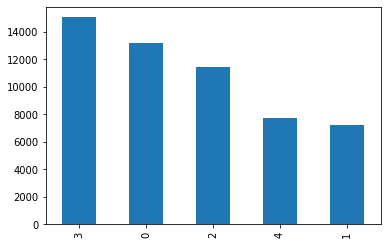

In [10]:
# author 개수 확인
train['author'].value_counts().plot(kind='bar')
plt.show()

## 2. 텍스트 전처리
### 1) 특수문자, 기호, 숫자 제거
### 2) 형태소 분석(토큰화)
### 3) 불용어 처리
### 4) stemming / lemmatization
 - 어간 추출과 표제어 추출은 코퍼스(말뭉치)에서 중복된 의미를 갖는 단어를 하나로 통합하기 위한 방법
  - 어간 추출: 단어의 뜻을 잃지 않는 선에서 단어의 앞부분만 추출
  - 표제어 추출: 단어의 기본형으로 변환

In [11]:
# 특수문자 및 기호, 숫자 제거
train['text'] = train['text'].str.replace('[^a-zA-Z ]', '', regex = True) # 영어 및 공백만 남기고 제거
train['text'] = train['text'].str.replace('^ +', '', regex = True) # 이중 공백 제거

<ipython-input-11-b08ff3e4b789>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['text'] = train['text'].str.replace('[^a-zA-Z ]', '', regex = True) # 영어 및 공백만 남기고 제거
<ipython-input-11-b08ff3e4b789>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['text'] = train['text'].str.replace('^ +', '', regex = True) # 이중 공백 제거


In [12]:
# 빈 값이 있다면 nan로 변환
train['text'].replace('', np.nan, inplace=True)
train

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,text,author
0,He was almost choking There was so much so muc...,3
1,Your sister asked for it I suppose,2
2,She was engaged one day as she walked in perus...,1
3,The captain was in the porch keeping himself c...,4
4,Have mercy gentlemen odin flung up his hands D...,3
...,...,...
54874,Is that you Mr Smith odin whispered I hardly d...,2
54875,I told my plan to the captain and between us w...,4
54876,Your sincere wellwisher friend and sister LUCY...,1
54877,Then you wanted me to lend you money,3


In [13]:
# 전처리 후 결측값 존재 확인
train['text'].isnull().sum()

2

In [14]:
# 결측값 대체
train = train.fillna(method='ffill')

# 결측값 대체 후 결측값 존재 확인
train['text'].isnull().sum()

0

### 형태소 분석 및 불용어 제거
- NLTK: 자연어 처리 및 분석을 위한 파이썬 패키지
- word_tokenize: 토큰화 도구 중 하나

In [15]:
# !pip install konlpy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')

stop_words = stopwords.words('english')
print('불용어 개수 :', len(stop_words))
print('불용어 10개 출력 :',stop_words[:10])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


불용어 개수 : 179
불용어 10개 출력 : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [16]:
# 불용어 처리 예시
example = "Family is not an important thing. It's everything."
stop_words = set(stopwords.words('english')) # 미리 정의된 영어 불용어
word_tokens = word_tokenize(example)

result = []
for word in word_tokens:
  if word not in stop_words:
    result.append(word)

print('불용어 제거 전 :',word_tokens) 
print('불용어 제거 후 :',result)

불용어 제거 전 : ['Family', 'is', 'not', 'an', 'important', 'thing', '.', 'It', "'s", 'everything', '.']
불용어 제거 후 : ['Family', 'important', 'thing', '.', 'It', "'s", 'everything', '.']


In [17]:
# 어간 추출 예시
sentence = 'A processing interface for removing morphological affixes from words. This process is known as stemming.'
tokens = word_tokenize(sentence)

pst = PorterStemmer() # porter 방법으로 stemming 인스턴스 생성
stemmed_tokens = [pst.stem(token) for token in tokens]
print(tokens)
print('\n')
print(stemmed_tokens)

['A', 'processing', 'interface', 'for', 'removing', 'morphological', 'affixes', 'from', 'words', '.', 'This', 'process', 'is', 'known', 'as', 'stemming', '.']


['a', 'process', 'interfac', 'for', 'remov', 'morpholog', 'affix', 'from', 'word', '.', 'thi', 'process', 'is', 'known', 'as', 'stem', '.']


In [18]:
# 표제어 추출 예시
sentence = 'A processing interface for removing morphological affixes from words. This process is known as stemming.'
tokens = word_tokenize(sentence)

wml = WordNetLemmatizer() # porter 방법으로 stemming 인스턴스 생성
lamm_tokens = [wml.lemmatize(token) for token in tokens]
print(tokens)
print('\n')
print(lamm_tokens)

['A', 'processing', 'interface', 'for', 'removing', 'morphological', 'affixes', 'from', 'words', '.', 'This', 'process', 'is', 'known', 'as', 'stemming', '.']


['A', 'processing', 'interface', 'for', 'removing', 'morphological', 'affix', 'from', 'word', '.', 'This', 'process', 'is', 'known', 'a', 'stemming', '.']


In [19]:
# 형태소 분석 + 불용어 제거 + 어간 추출
from tqdm import tqdm
pst = PorterStemmer()
train_feature = [] # 토큰화 + 불용어 제거가 적용된 데이터의 저장 공간

for sentence in tqdm(train['text']):
  tokenized_sentences = word_tokenize(sentence) # 토큰화
  stopwords_removed_sentence = [pst.stem(word) for word in tokenized_sentences if not word in stop_words] # 불용어 제거 & stemming & 소문자 변환
  train_feature.append(stopwords_removed_sentence)

100%|██████████| 54744/54744 [00:54<00:00, 1000.36it/s]


In [23]:
train_feature

[['he',
  'almost',
  'choke',
  'there',
  'much',
  'much',
  'want',
  'say',
  'strang',
  'exclam',
  'came',
  'lip',
  'the',
  'pole',
  'gaze',
  'fixedli',
  'bundl',
  'note',
  'hand',
  'look',
  'odin',
  'evid',
  'perplex'],
 ['your', 'sister', 'ask', 'i', 'suppos'],
 ['she',
  'engag',
  'one',
  'day',
  'walk',
  'perus',
  'jane',
  'last',
  'letter',
  'dwell',
  'passag',
  'prove',
  'jane',
  'written',
  'spirit',
  'instead',
  'surpris',
  'mr',
  'odin',
  'saw',
  'look',
  'odin',
  'meet',
  'put',
  'away',
  'letter',
  'immedi',
  'forc',
  'smile',
  'said'],
 ['the',
  'captain',
  'porch',
  'keep',
  'care',
  'way',
  'treacher',
  'shot',
  'intend',
  'he',
  'turn',
  'spoke',
  'us',
  'doctor',
  'watch',
  'lookout',
  'dr',
  'odin',
  'take',
  'north',
  'side',
  'pleas',
  'jim',
  'east',
  'gray',
  'west',
  'the',
  'watch',
  'hand',
  'load',
  'musket',
  'live',
  'men',
  'care'],
 ['have',
  'merci',
  'gentlemen',
  'odin',


### 정수 인코딩

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_feature)
print(tokenizer.word_index) # 가장 낮은 정수를 얻은 'i' 단어의 등장 빈도수가 가장 높음

{'i': 1, 'odin': 2, 'said': 3, 'mr': 4, 'one': 5, 'the': 6, 'he': 7, 'would': 8, 'it': 9, 'could': 10, 'look': 11, 'upon': 12, 'man': 13, 'but': 14, 'know': 15, 'come': 16, 'and': 17, 'you': 18, 'time': 19, 'say': 20, 'like': 21, 'see': 22, 'go': 23, 'well': 24, 'hand': 25, 'littl': 26, 'think': 27, 'cri': 28, 'must': 29, 'she': 30, 'much': 31, 'what': 32, 'even': 33, 'ask': 34, 'good': 35, 'us': 36, 'never': 37, 'thought': 38, 'day': 39, 'may': 40, 'sir': 41, 'dont': 42, 'two': 43, 'there': 44, 'make': 45, 'eye': 46, 'made': 47, 'last': 48, 'noth': 49, 'that': 50, 'though': 51, 'face': 52, 'came': 53, 'way': 54, 'ye': 55, 'take': 56, 'old': 57, 'great': 58, 'word': 59, 'might': 60, 'shall': 61, 'back': 62, 'first': 63, 'long': 64, 'seem': 65, 'turn': 66, 'miss': 67, 'away': 68, 'thing': 69, 'tell': 70, 'without': 71, 'everi': 72, 'still': 73, 'hous': 74, 'room': 75, 'head': 76, 'went': 77, 'quit': 78, 'give': 79, 'young': 80, 'friend': 81, 'get': 82, 'answer': 83, 'someth': 84, 'a': 8

In [22]:
print(tokenizer.word_counts) # 각 단어의 빈도수 확인

OrderedDict([('he', 7602), ('almost', 1127), ('choke', 47), ('there', 2772), ('much', 3325), ('want', 1855), ('say', 4526), ('strang', 817), ('exclam', 99), ('came', 2609), ('lip', 441), ('the', 7665), ('pole', 75), ('gaze', 307), ('fixedli', 24), ('bundl', 120), ('note', 535), ('hand', 3991), ('look', 5610), ('odin', 39685), ('evid', 630), ('perplex', 88), ('your', 909), ('sister', 1012), ('ask', 3236), ('i', 53446), ('suppos', 1055), ('she', 3328), ('engag', 479), ('one', 7848), ('day', 2932), ('walk', 1496), ('perus', 22), ('jane', 376), ('last', 2660), ('letter', 1067), ('dwell', 78), ('passag', 298), ('prove', 329), ('written', 274), ('spirit', 678), ('instead', 245), ('surpris', 827), ('mr', 8724), ('saw', 1704), ('meet', 616), ('put', 1827), ('away', 2326), ('immedi', 501), ('forc', 394), ('smile', 1141), ('said', 13441), ('captain', 690), ('porch', 25), ('keep', 1013), ('care', 837), ('way', 2609), ('treacher', 13), ('shot', 219), ('intend', 210), ('turn', 2352), ('spoke', 651)